In [80]:
import numpy as np
import matplotlib.pyplot as plt

from kf_lab.models.motion.cv import CV2D
from kf_lab.models.measurement.range_bearing import RangeBearing2D
from kf_lab.filters.ekf import EKF
from kf_lab.sims.scenarios import mission_u_turn_accel_zigzag, zigzag_cv, straight_cv
from kf_lab.sensors.sampler import simulate_measurements

# If you saved the tuner class as:
from kf_lab.tuners.covariance_matching_r import CovarianceMatchingRTuner


In [81]:
# =====================================
# Scenario: U-turn + accel + zigzag
# =====================================
DURATION_S = 120
TRUTH_DT = 0.1
SENSOR_HZ = 5.0

truth, t_truth = straight_cv(
    duration_s=DURATION_S,
    truth_dt=TRUTH_DT,
    offset_xy=(100, 100)
)

sensor = RangeBearing2D(
    xs=0.0, ys=0.0,
    sigma_r=5.0,
    sigma_b=np.deg2rad(0.5)
)

t_meas, Z = simulate_measurements(
    truth, t_truth, sensor, sensor_hz=SENSOR_HZ
)

dt = 1.0 / SENSOR_HZ



In [82]:
def run_filter(use_tuner=False):
    # Initial state guess
    x0 = np.array([truth[0,0], truth[0,1], 0, 0])
    P0 = np.diag([200, 200, 50, 50])

    motion = CV2D(q=1.0)
    ekf = EKF(x0, P0, motion, sensor)

    # If tuner enabled
    if use_tuner:
        R0 = sensor.R(x0)
        tuner = CovarianceMatchingRTuner(
            R0=R0, window=20, alpha=0.05
        )
    else:
        tuner = None

    estimates = []
    Rs = []
    innov_norms = []

    for z in Z:
        # Predict
        if tuner is not None:
            R_use = tuner.current_R()
            ekf.predict(dt)
            ekf.update(z, R_override=R_use)
            tuner.update_from_ekf(ekf)
            Rs.append(R_use.copy())
        else:
            ekf.predict(dt)
            ekf.update(z)
            Rs.append(sensor.R(ekf.x).copy())  # fixed

        estimates.append(ekf.x.copy())

        # innovation magnitude for plotting
        nu = ekf.last_innovation
        innov_norms.append(np.linalg.norm(nu))

    return np.array(estimates), np.array(Rs), np.array(innov_norms)


In [83]:
est_fixed, R_fixed, innov_fixed = run_filter(use_tuner=False)
est_adapt, R_adapt, innov_adapt = run_filter(use_tuner=True)


In [84]:
truth_xy = truth[:, :2]
fixed_xy = est_fixed[:, :2]
adapt_xy = est_adapt[:, :2]

err_fixed = np.linalg.norm(fixed_xy - truth_xy[:len(fixed_xy)], axis=1)
err_adapt = np.linalg.norm(adapt_xy - truth_xy[:len(adapt_xy)], axis=1)


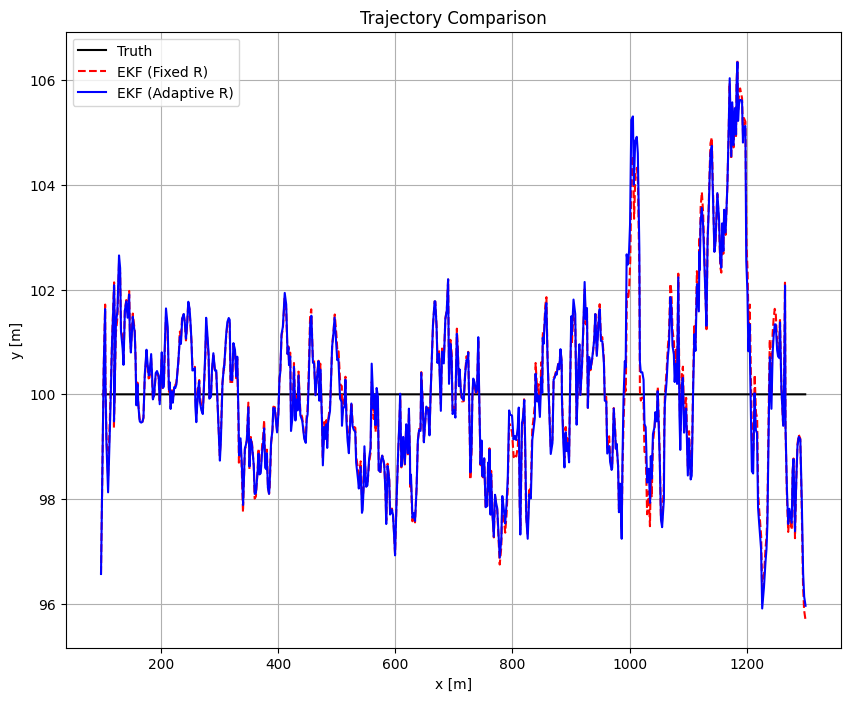

In [85]:
plt.figure(figsize=(10,8))
plt.plot(truth[:,0], truth[:,1], 'k-', label="Truth")
plt.plot(fixed_xy[:,0], fixed_xy[:,1], 'r--', label="EKF (Fixed R)")
plt.plot(adapt_xy[:,0], adapt_xy[:,1], 'b-', label="EKF (Adaptive R)")
plt.legend()
plt.title("Trajectory Comparison")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True)
plt.show()


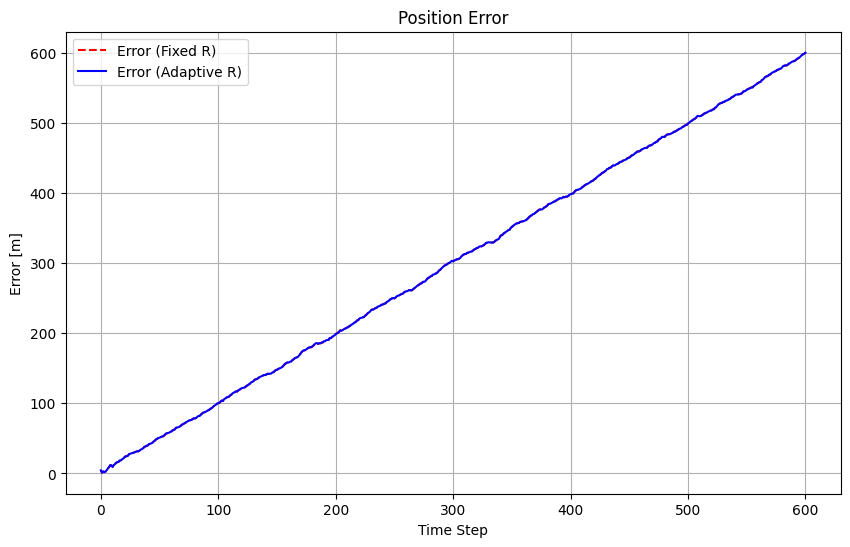

In [86]:
plt.figure(figsize=(10,6))
plt.plot(err_fixed, 'r--', label="Error (Fixed R)")
plt.plot(err_adapt, 'b-', label="Error (Adaptive R)")
plt.legend()
plt.title("Position Error")
plt.xlabel("Time Step")
plt.ylabel("Error [m]")
plt.grid(True)
plt.show()


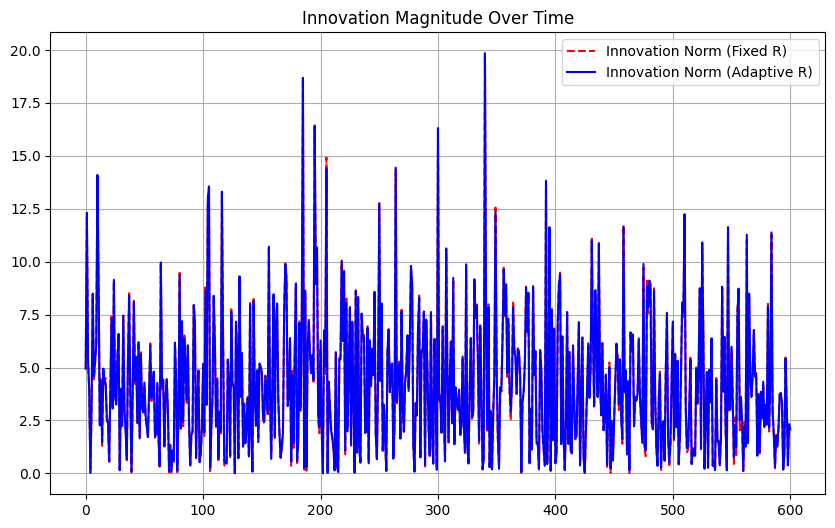

In [87]:
plt.figure(figsize=(10,6))
plt.plot(innov_fixed, 'r--', label="Innovation Norm (Fixed R)")
plt.plot(innov_adapt, 'b-', label="Innovation Norm (Adaptive R)")
plt.legend()
plt.title("Innovation Magnitude Over Time")
plt.grid(True)
plt.show()


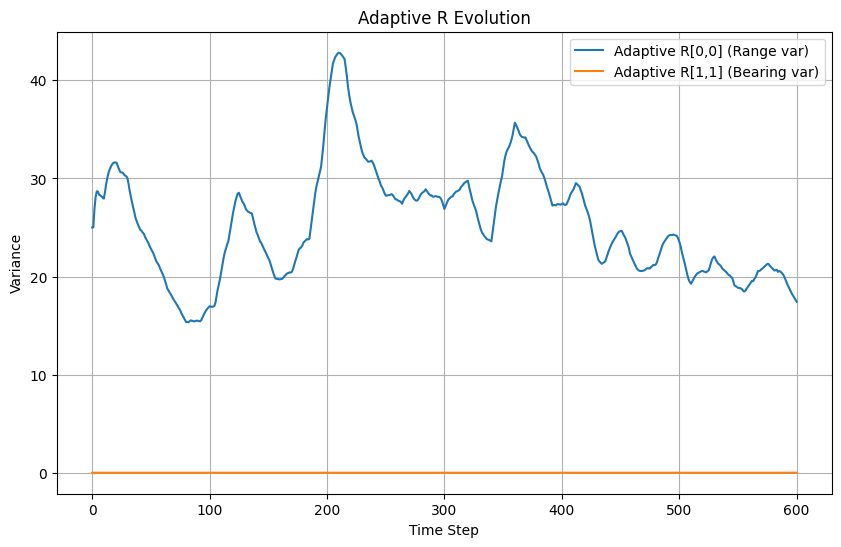

In [88]:
plt.figure(figsize=(10,6))
plt.plot(R_adapt[:,0,0], label="Adaptive R[0,0] (Range var)")
plt.plot(R_adapt[:,1,1], label="Adaptive R[1,1] (Bearing var)")
plt.title("Adaptive R Evolution")
plt.xlabel("Time Step")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.show()
